In [2]:
from fileinput import filename
import sqlite3
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import FastText
from nltk.tokenize import word_tokenize
import csv
import io
import fasttext
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import os
import string
import re
from sklearn.metrics.pairwise import cosine_similarity
from gensim.test.utils import get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
import matplotlib.pyplot as plt

In [14]:
## ques1_1
filen = 'GoogleNews-vectors-negative300.bin'
word_vectors=KeyedVectors.load_word2vec_format(filen,
binary=True, unicode_errors='ignore')

sentence1='No banks to deposit money near the river bank'
sentence2='Stick to the rule by stirring with a wood stick'

word_tokens1=word_tokenize(sentence1)
list1=[]

for x in word_tokens1:
    if x in word_vectors.index_to_key:       
        words=word_vectors.most_similar(x)
        list1.append(words)
dict1={k:v for k,v in zip(word_tokens1,list1)}
sentence1_most_similar=pd.DataFrame(dict1)
print(sentence1_most_similar)

word_tokens2=word_tokenize(sentence2)
list2=[]
for x in word_tokens2:
    if x in word_vectors:       
        words=word_vectors.most_similar(positive=x)
        list2.append(words)
dict2={k:v for k,v in zip(word_tokens2,list2)}
sentence2_most_similar=pd.DataFrame(dict2)
print(sentence2_most_similar)



                              No                                   banks  \
0       (no, 0.7029597759246826)              (bank, 0.7440758347511292)   
1   (Nobody, 0.6824341416358948)            (lenders, 0.660046398639679)   
2      (None, 0.608828604221344)           (banking, 0.6438172459602356)   
3  (Nothing, 0.5618352293968201)  (mortgage_lenders, 0.6358486413955688)   
4   (nobody, 0.5327647924423218)         (megabanks, 0.6172765493392944)   
5      (Not, 0.5226895809173584)      (institutions, 0.6150783896446228)   
6      (any, 0.5202820897102356)        (brokerages, 0.6133029460906982)   
7  (Neither, 0.5181751847267151)            (lender, 0.6090298295021057)   
8   (Hardly, 0.5112018585205078)        (depositors, 0.6050993204116821)   
9     (Nope, 0.5034330487251282)             (Banks, 0.6024675369262695)   

                                                  to  \
0                     (deposits, 0.8111314177513123)   
1                      (Deposit, 0.7686398029327393

# Q: Which of the word's meaning do not match the returned results? Why do you think they did not work?

A:  

For sentence 1, they are 'to', 'money', 'the', 'river'. 

For sentence 2, they are 'the', 'rule', 'by', 'stirring','with', 'a'
    
Not removing stopwords may cause this trouble. If we remove stopwords, dataset size decreases and contains less but meaningful tokens only. That means it could help to improve the performance.

In [6]:
## ques1_2

q1_2_1=word_vectors.most_similar(positive=['worse', 'good'], negative=['better'])[:10]
q1_2_2=word_vectors.most_similar(positive=['China', 'dollar'], negative=['U.S.'])[:10]
ques1_2 = pd.DataFrame( {'q1_2_1':q1_2_1, 'q1_2_2':q1_2_2})
print(ques1_2)

                             q1_2_1                               q1_2_2
0         (bad, 0.7338365912437439)           (yuan, 0.6090352535247803)
1    (terrible, 0.6607799530029297)       (renminbi, 0.5777851343154907)
2    (horrible, 0.6248188018798828)            (Yuan, 0.576006293296814)
3       (awful, 0.5503717660903931)       (renmimbi, 0.5750775337219238)
4    (dreadful, 0.5382158756256104)            (RMB, 0.5670680999755859)
5  (horrendous, 0.5362171530723572)       (currency, 0.5354732871055603)
6       (scary, 0.5213475823402405)       (Renminbi, 0.5279375314712524)
7       (nasty, 0.5204606652259827)        (reminbi, 0.5102971792221069)
8       (lousy, 0.5173133611679077)  (renminbi_yuan, 0.5097711682319641)
9        (ugly, 0.5073913335800171)       (USdollar, 0.5083441734313965)


# Q: How do the results compare to GLOVE results in our lecture slides?

A: 
With skip-gram model, Glove result return the similar value with cosine_similarity for `better:good :: worse: bad' is 0.99868

With cbow model, the cosine similarity for those words is much lower compared to Word2Vec.

In [16]:
## QUES_1_3

def get_word2vec_matrix(words_list):
    filen = 'GoogleNews-vectors-negative300.bin'
    word_vectors=KeyedVectors.load_word2vec_format(filen,binary=True, unicode_errors='ignore')
    new_list=sorted(words_list)
    vectors=[]
    non_exist=[]
    value =[]
    key=[]
    for x in new_list:
        if x in word_vectors:       
            words=word_vectors.get_vector(x)
            vectors.append(words)
            key.append(x)
        else:
            words=x
            non_exist.append(words)
    M=vectors
    for i in range(0,len(key)):
        value.append(i)
    word2Ind = {k:v for k,v in zip(key,value)}
    return M, word2Ind, non_exist

In [18]:
## PREPROCESSING - FOR 1.4, 1.5, 1.6, 1.7

stoplist=stopwords.words('english')
x= 'A large oil spill off the southern California coast was described as an “environmental catastrophe” by the mayor of Huntington Beach on Sunday, as the breach of an oil rig pipeline left dead fish and birds strewn on the sand and offshore wetlands clogged with oil. An estimated 126,000 gallons, or 3,000 barrels, had spread into an oil slick covering about 13 square miles of the Pacific Ocean since it was first reported on Saturday morning, said the mayor of Huntington Beach, at a press conference. The beachside city, about 40 miles south of Los Angeles, was bearing the brunt of the spill'
word_tokens=word_tokenize(x.lower())
wordslist = []
for word in word_tokens:
    if word.lower() not in stoplist:
        wordslist.append(word)
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
words = tokenizer.tokenize(str(wordslist))
words_list=sorted(set(words))

In [23]:
## QUES_1_4 

Mat=get_word2vec_matrix(words_list)[0]
word2Ind=get_word2vec_matrix(words_list)[1]
non_exist=get_word2vec_matrix(words_list)[2]
ques1_4 = {'word2Ind':word2Ind, 'non_exist':non_exist}
print(Mat)
print(ques1_4)

[array([-0.06079102, -0.03369141,  0.06933594,  0.07519531, -0.16015625,
        0.04711914,  0.0090332 , -0.03808594, -0.07226562,  0.04711914,
       -0.10791016,  0.0078125 , -0.07910156,  0.08740234,  0.15917969,
        0.12597656,  0.08886719,  0.16796875,  0.03051758, -0.11328125,
       -0.10888672,  0.00442505,  0.00291443,  0.03417969, -0.05151367,
       -0.09130859, -0.02563477,  0.05859375, -0.05859375, -0.15039062,
        0.1875    ,  0.02307129, -0.03515625,  0.02001953, -0.11474609,
        0.04272461, -0.02160645,  0.01843262,  0.0402832 , -0.125     ,
       -0.04931641, -0.05957031,  0.09326172,  0.09033203, -0.02453613,
        0.02600098, -0.1171875 , -0.19824219, -0.01434326,  0.109375  ,
       -0.22558594,  0.13769531,  0.06005859,  0.05664062,  0.00561523,
        0.0859375 , -0.02709961, -0.109375  ,  0.03979492,  0.01928711,
       -0.04931641,  0.02734375, -0.04296875, -0.23925781,  0.00292969,
       -0.10400391, -0.03759766,  0.00122833, -0.0030365 , -0.0

[[-0.86712664  0.2617749 ]
 [ 2.6501489   0.31449905]
 [-0.00523835  1.2636766 ]
 [-0.270847    1.0277731 ]
 [-0.4968342  -0.72711205]
 [ 0.69895947  0.4203383 ]
 [ 0.0082139  -0.553521  ]
 [-0.32106426 -1.4388627 ]
 [-2.2750547   1.9710871 ]
 [ 0.31963488 -0.17919514]
 [-0.15327415 -0.33985424]
 [-0.14960921 -0.8097087 ]
 [ 0.1960553   1.1060205 ]
 [-0.4101487  -0.8144518 ]
 [-0.3043463  -0.62870926]
 [-0.1406548  -0.36384606]
 [-0.25607646 -0.91992825]
 [ 0.44424045 -0.06620728]
 [ 0.42289084 -0.8854591 ]
 [-0.3095381  -0.54502857]
 [ 0.5969024   0.5737106 ]
 [ 2.4135296   0.25405464]
 [-1.0526234   0.6275066 ]
 [-0.22981304 -0.6038674 ]
 [-0.289943   -0.72348017]
 [-1.7661444   0.74180925]
 [-0.23133956 -0.51513994]
 [ 0.46739456  0.10731517]
 [-0.50906175 -0.40276912]
 [ 0.5181467   1.3242457 ]
 [ 0.8162179   0.83284116]
 [ 1.2432673   0.40163487]
 [-1.0308635   0.8945591 ]
 [ 1.0734955  -0.06533621]
 [-0.49834883 -0.63582915]
 [-0.22330016 -1.084831  ]
 [ 1.0392247   0.6650889 ]
 

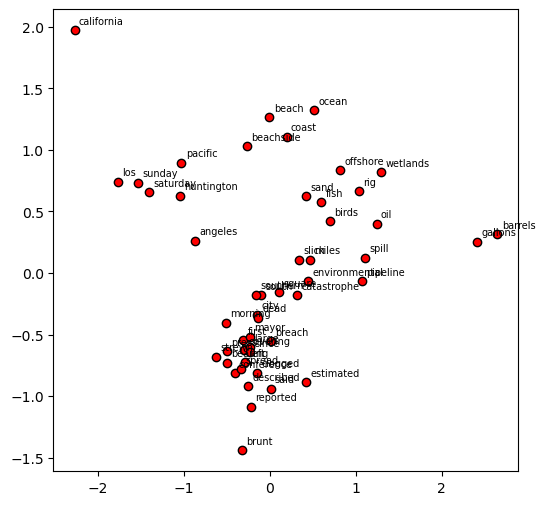

In [25]:
## QUES_1_5

def project_on_pca(model, words=None, sample=0, fname ='pca2.JPG'):
    if words == None:
        if sample > 0:
            words = np.random.choice(model.index_to_key, sample)
        else:
            words = [ word for word in model.index_to_key]
    word_vectors = np.array([model[w] for w in words])
    two_d = PCA().fit_transform(word_vectors)[:,:2]
    plt.figure(figsize=(6,6))
    plt.scatter(two_d[:,0], two_d[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, two_d):
        plt.text(x+0.05, y+0.05, word, fontsize=7)
    plt.savefig(fname)
    return two_d
filen = 'GoogleNews-vectors-negative300.bin'
word_vectors=KeyedVectors.load_word2vec_format(filen, binary=True, unicode_errors='ignore')
M2d_word2vec=project_on_pca(word_vectors, words_list, fname ='pca.JPG')
print(M2d_word2vec)

[array([ 2.7895e-01, -1.4513e-01, -3.3142e-01, -1.1675e-02,  1.2969e-01,
        1.9426e-01,  4.4715e-02, -7.1627e-02,  1.5415e-01, -9.0665e-02,
        2.1428e-01,  1.9680e-01, -5.1458e-02,  1.5618e-01,  2.8086e-01,
       -1.7250e-01, -2.6675e-02, -9.0859e-02,  6.4279e-02,  2.0549e-01,
       -2.9068e-01, -2.2891e-01, -7.2530e-02, -1.2940e-01,  9.3061e-03,
        1.8210e-01,  3.0013e-02, -2.6598e-01, -1.4630e-01, -5.8432e-01,
       -4.1312e-02,  6.0036e-01, -9.7986e-02,  1.2295e-01, -1.2372e+00,
       -4.9430e-01, -2.8114e-01, -3.3814e-01, -1.6554e-01, -2.0483e-01,
        1.9603e-01, -3.2115e-01,  1.0596e-01,  6.1611e-01,  3.7763e-01,
       -4.0923e-02,  2.3409e-01,  3.7534e-01,  3.3821e-01,  8.3361e-02,
        3.4362e-01, -1.3905e-01, -2.1378e-01, -3.4427e-01, -8.1631e-02,
       -2.5965e-01, -6.2445e-01, -4.5146e-02, -1.2470e-01, -1.1097e+00,
       -9.8053e-01,  1.4594e-01,  3.2790e-01,  5.4909e-01,  1.1552e-01,
       -4.1737e-01, -2.3562e-01,  1.5824e-01,  1.9193e-01, -6.0

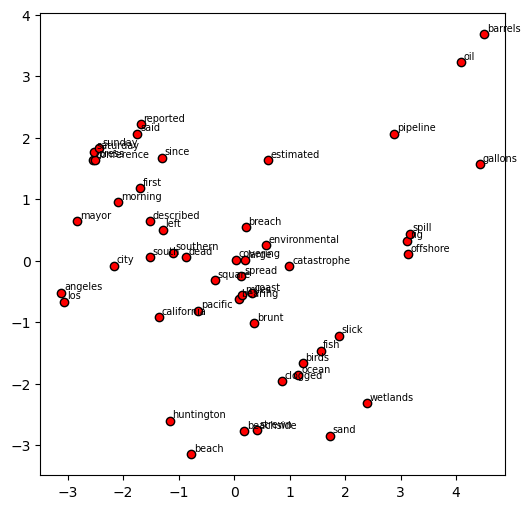

In [26]:
## QUES_1_6

def load_glove():
    word_vectors = {}
    path = 'D:/downloads/glove.6B.300d.txt'
    f = open(path, 'r', encoding ='UTF-8')
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        word_vectors[word] = vectors
    f.close()
    return word_vectors

def get_glove_matrix(words_list ):
    word_vectors = load_glove()
    new_list=sorted(words_list)
    vectors=[]
    non_exist=[]
    value =[]
    key=[]
    for x in new_list:
        if x in word_vectors:       
            words=word_vectors[x]
            vectors.append(words)
            key.append(x)
        else:
            words=x
            non_exist.append(words)
    M=vectors
    for i in range(0,len(key)):
        value.append(i)
    word2Ind = {k:v for k,v in zip(key,value)}
    return M, word2Ind, non_exist

word_vectors = load_glove()
Mat_glove=get_glove_matrix(words_list)[0]
word2Ind=get_glove_matrix(words_list)[1] 
non_exist=get_glove_matrix(words_list)[2]
ques1_4_glove = {'word2Ind':word2Ind, 'non_exist':non_exist}
M2d_glove=project_on_pca(word_vectors, words_list, fname ='pca.JPG')
print(Mat_glove)
print(ques1_4_glove)
print(M2d_glove)

[array([ 7.130e-02,  1.290e-02, -1.349e-01, -1.050e-01, -7.120e-02,
        1.145e-01, -1.600e-02,  4.170e-02,  9.510e-02, -4.180e-02,
       -2.200e-02, -9.850e-02,  5.440e-02,  7.590e-02,  1.528e-01,
        2.224e-01,  4.200e-03, -1.312e-01,  2.178e-01, -1.870e-01,
       -2.516e-01, -1.284e-01,  1.174e-01, -8.000e-04, -1.460e-02,
       -9.410e-02,  9.280e-02,  3.450e-02, -1.549e-01, -1.262e-01,
        9.080e-02, -2.451e-01,  4.920e-02,  1.331e-01,  8.180e-02,
       -6.800e-03, -1.228e-01, -1.752e-01,  1.154e-01,  1.570e-02,
        5.000e-02,  3.000e-04, -2.097e-01, -1.727e-01,  9.630e-02,
        1.690e-02, -8.510e-02,  5.700e-02, -1.150e-02,  2.000e-02,
       -4.200e-03,  2.320e-02, -8.479e-01,  3.600e-02, -1.705e-01,
        1.620e-02, -2.235e-01,  1.635e-01,  2.807e-01,  1.020e-01,
       -3.120e-02, -1.529e-01, -3.650e-02, -3.520e-02,  9.600e-02,
       -5.530e-02,  1.427e-01,  1.630e-01, -4.810e-02,  3.080e-02,
       -6.520e-02,  9.130e-02,  6.150e-02, -9.990e-02, -1.636

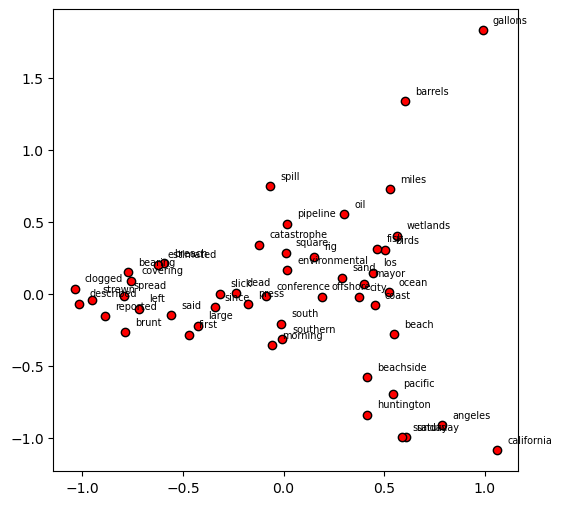

In [27]:
## QUES1_7
x= 'A large oil spill off the southern California coast was described as an “environmental catastrophe” by the mayor of Huntington Beach on Sunday, as the breach of an oil rig pipeline left dead fish and birds strewn on the sand and offshore wetlands clogged with oil. An estimated 126,000 gallons, or 3,000 barrels, had spread into an oil slick covering about 13 square miles of the Pacific Ocean since it was first reported on Saturday morning, said the mayor of Huntington Beach, at a press conference. The beachside city, about 40 miles south of Los Angeles, was bearing the brunt of the spill'
import json
answer_text = json.dumps(x)
textfile = open('training_text.txt', 'w')
textfile.write(answer_text)
textfile.close()
filen='training_text.txt'

def load_fasttext(fname='D:/downloads/wiki-news-300d-1M.vec'):
    word_vectors = {}
    f=io.open(fname,'r',encoding='utf-8',newline='\n',
    errors='ignore')
    for line in f:
        values = line.strip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_vectors[word] = coefs
    f.close()
    return word_vectors

def get_fasttext_matrix(words_list, training_text ):
    word_vectors=load_fasttext()
    new_list=sorted(words_list)
    word2Ind={}
    value =[]
    key=[]
    key_new=[]
    value_new=[]
    M_new=[]
    word2Ind_new=[]
    M=[]
    model=fasttext.train_unsupervised(training_text,model='skipgram')
    for x in new_list:
        if x in word_vectors:       
            words=word_vectors[x]
            M.append(words)
            key.append(x)
        else:
            words=model[x]
            M_new.append(words)
            key_new.append(x)
    for i in range(0,len(key)):
        value.append(i)
    for i in range(0,len(key_new)):
        value_new.append(i)
    word2Ind = {k:v for k,v in zip(key,value)}
    word2Ind_new = {k:v for k,v in zip(key_new,value_new)}
    return M, word2Ind, M_new, word2Ind_new

word_vectors=load_fasttext()
Mat_fasttext=get_fasttext_matrix(words_list,filen)[0]
word2Ind=get_fasttext_matrix(words_list,filen)[1] 
word2Ind_new=get_fasttext_matrix(words_list,filen)[3]
ques1_4_fasttext = {'word2Ind':word2Ind, 'word2Ind_new': word2Ind_new}
M2d_fasttext=project_on_pca(word_vectors, words_list, fname ='pca.JPG')
print(Mat_fasttext)
print(ques1_4_fasttext)
print(M2d_fasttext)

# QUES1_8

By using plot from part (5), (6), (7), I believe Fasttext's performance is better than the other two. it's good to show words cluster which includes relating words together like 'beach', 'sand', 'beachside', 'pacific', 'hungtinton', 'saturday', 'sunday', 'angeles', 'california' or 'environment', 'square', 'catastrophe', 'rig' or 'south', southern', 'morning'. 

The performance of Glove is followed. It helps to group 'spill', 'rig', 'offshore' or 'sunday', 'saturday', 'conference'. However, for some relevant words, such as 'hungtinton', 'beach', 'sand', 'beachside' or 'oil', pipeline', 'rig', 'spill', 'offshore', it fails to group them together.

Word2vec is likely to give the worse result compared to the two above. Except some of them are clustered together correctly (such as:'beach', 'ocean', 'coast', 'beachside' or 'reported', 'described', 'said'), most of them are clustered even they are not related to each other.



In [30]:
## QUES2_A

from nltk import tokenize

def get_unique_word(docs):
    string=[]
    sub_string=[]
    for i in docs:
        new_i=tokenize.sent_tokenize(i)
        for x in new_i:
            sub_string.append(x)
    string.append(sub_string)
    new_docs=string[0]
    corpus_words = []
    for text in new_docs:
        docs=text.replace('\\n',' ')
        docs2=docs.replace('-',' ')
        newstr = re.sub(u'[\u2019]', ' ', docs2)
        word_tokens=word_tokenize(newstr.lower())
        tokenizer = RegexpTokenizer(r'[a-z]+')
        words = tokenizer.tokenize(str(word_tokens))
        corpus_words.append(words)
        unique_word = sorted(set(x for l in corpus_words for x in l))
    num_words=len(unique_word)
    return unique_word, num_words,corpus_words

def co_occurrence(docs, k=2):
    
    M = None
    word2Ind = {}
    words = get_unique_word(docs)[0]
    num_words = get_unique_word(docs)[1]
    corpus_words=get_unique_word(docs)[2]
    for i in range(len(words)):
        word2Ind[words[i]]=i
    M=np.zeros((num_words,num_words)) 
    for word in corpus_words:
        for i in range(len(word)):
            target=word[i]
            target_index=word2Ind[target]
            
            left = max(i - k, 0)
            for j in range(left, i):
                window_word = word[j]
                M[target_index][word2Ind[window_word]] += 1
                M[word2Ind[window_word]][target_index] += 1

    return M, word2Ind


In [32]:
# QUES2_B     M is co-occurrence matrix.

from sklearn.decomposition import TruncatedSVD

def SVD_embedding( M,  m=2):
    n_iters = 10
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    svd=TruncatedSVD(n_components=m,n_iter=n_iters,random_state=123,tol=0)
    M_reduced=svd.fit_transform(M)
    return M_reduced

In [33]:
## QUES2_C

def plot_embeddings(M_reduced, word2Ind, words):
    for i, word in enumerate(words):
        coor=M_reduced[i]
        x = coor[0]
        y = coor[1]
        plt.scatter(x, y, edgecolors='k', c='r')
        plt.text(x + 0.009, y + 0.009, word, fontsize=6)
    plt.show()
    return M_reduced



[[500.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   1.   0.]
 [  0.   0.   0. ...   1.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
Running Truncated SVD over 14729 words...


c:\Users\dnvqu\anaconda3\envs\bebe\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


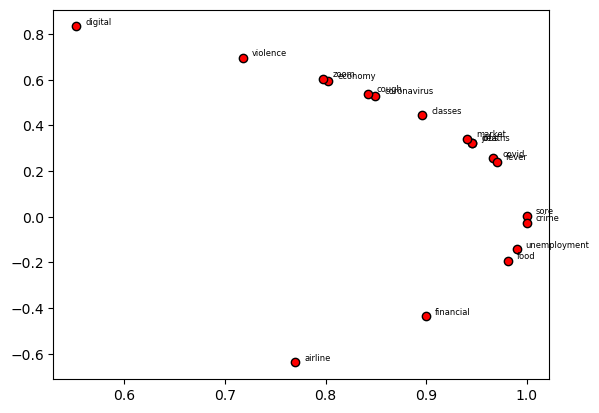

array([[0.96655516, 0.2564588 ],
       [0.84900012, 0.52839266],
       [0.97044002, 0.24134242],
       ...,
       [0.85907017, 0.51185784],
       [0.85106895, 0.52505394],
       [0.7987727 , 0.60163292]])

In [48]:
## QUES2_D
import sqlite3
from nltk.tokenize import word_tokenize
con = sqlite3.connect('reuters_news_articles.sqlite')
cur = con.cursor()
cur.execute('SELECT article FROM reuters_news WHERE INSTR(article, "coronavirus")>0')
rows=cur.fetchall()
con.close()
docs=(rows[:500])
reuters_docs=[]
for doc in docs:
    reuters_docs.append(str(doc))


M, word2Ind = co_occurrence(reuters_docs, k=4)
print(M)
M_reduced = SVD_embedding(M, m=2)
# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_normalized = M_reduced/M_lengths[:, np.newaxis] # broadcasting
words = ['covid', 'coronavirus', 'fever', 'sore', 'cough', 'deaths', 'unemployment', 'food','financial', 'jobs', 'market', 'airline','economy', 'digital', 'zoom', 'classes', 'violence', 'crime']
plot_embeddings(M_normalized, word2Ind, words)

# What words cluster together in the 2-d embedding space? 
'covid',  'fever', 'death'
'sore', 'crime'
'coronavirus','cough'
'economy', 'zoom'
'unemployment', 'food'

# What words don't cluster together but you think they should have? How does this embedding model perform?
'covid', 'coronavirus'

This embedding model perform not really well. Although some bunches of words like 'covid', 'fever', 'death' and 'coranavirus', 'cough'.. are clustered appropriately , the pair 'covid'-'coronavirus' and some of their related words locate apart on the graph.
This could be due to the size of datasize is not large enough. Not removing unuseful words could also be a reason. 

In [4]:
## PREPROCESSING - FOR 3_1, 3_2, 3_3

import sqlite3
con = sqlite3.connect('reuters_news_articles.sqlite')
cur = con.cursor()
cur.execute('SELECT article FROM reuters_news WHERE INSTR(article, "coronavirus")>0')
rows=cur.fetchall()
con.close()
docs=[]
for row in rows:
    docs.append(row[0])
reuters_docs=""
for text in docs:
    reuters_docs+= " " + text
reuters_docs = reuters_docs.lower()
reuters_docs=re.sub('[^a-z]+', ' ', reuters_docs)
import json
answer_text = json.dumps(reuters_docs)
textfile = open('training_fasttext.txt', 'w')
textfile.write(answer_text)
textfile.close()


In [6]:
## QUES_3_1

filen='training_fasttext.txt'
model=fasttext.train_unsupervised(filen,model='skipgram')
model.save_model('ques3fasttext.bin')
model = fasttext.load_model('ques3fasttext.bin')
list_nearest=model.get_nearest_neighbors('coronavirus', k=10)
nearest=pd.DataFrame(list_nearest)
print(nearest)

          0                1
0  0.906701            covid
1  0.855936  betacoronavirus
2  0.825111    coronaviruses
3  0.777163          disease
4  0.775682         outbreak
5  0.767565            novel
6  0.749136         pandemic
7  0.706308             amid
8  0.681183            virus
9  0.657828           amidst


# Comment on the result accuracy.
This gives a high acurracy result since outputs are likely exact the top 10 words which are nearest neighbors of 'coronavirus'. The top 3 are related names of 'coronavirus' while the others are its tags which can be seen quite frequently.

In [7]:
## QUES3_2

word_vector1=model['covid']
word_vector2=model['fly']
word_vector1=model['flu']

ita=[model['coronavirus']]
covid=cosine_similarity([model['covid']], ita)
fly=cosine_similarity([model['fly']], ita)
flu=cosine_similarity([model['flu']], ita)
ques3_2={'sim_covid_coronavirus':covid, 'sim_fly_coronavirus':fly,'sim_flu_coronavirus':flu}
print(ques3_2)

{'sim_covid_coronavirus': array([[0.90670055]], dtype=float32), 'sim_fly_coronavirus': array([[0.22139186]], dtype=float32), 'sim_flu_coronavirus': array([[0.38766515]], dtype=float32)}


# Comment on the result accuracy.
In term of cosine similarity, the output for pair of 'coronavirus' and 'covid' is 0.9067 which is corresponding to the truth that 'covid' is another name of 'coronavirus'. The statistics for other pairs are pretty low (0.221 for coronavirus-fly and 0.387 for coronavirus-flu). It's aslo relevant with the fact that coronavirus is not flu and has no relation to 'fly'

{'airline': 0, 'classes': 1, 'coronavirus': 2, 'cough': 3, 'covid': 4, 'crime': 5, 'deaths': 6, 'digital': 7, 'economy': 8, 'fever': 9, 'financial': 10, 'food': 11, 'jobs': 12, 'market': 13, 'sore': 14, 'unemployment': 15, 'violence': 16, 'zoom': 17}
{'sim_covid_coronavirus': '0.90670055', 'sim_fly_coronavirus': '0.22139186', 'sim_flu_coronavirus': '0.38766515'}
[[-1.196382   -0.41280943]
 [ 0.24704538  1.3975104 ]
 [-0.04177939 -0.32586414]
 [ 2.3050022  -0.96100104]
 [ 0.16800758 -0.42661574]
 [ 0.34433934  1.3192036 ]
 [ 0.1364923  -0.63095504]
 [-0.5965037   1.1078925 ]
 [-1.1012615  -0.74981153]
 [ 2.7690847  -0.27278805]
 [-1.2572131   0.28581655]
 [-0.13985996 -0.23344363]
 [-1.3656689  -1.0921803 ]
 [-0.8775993  -0.23615326]
 [ 1.5083791  -0.72262657]
 [-1.1323335  -1.4882463 ]
 [ 0.53487515  0.8786493 ]
 [-0.30462384  2.5634232 ]]


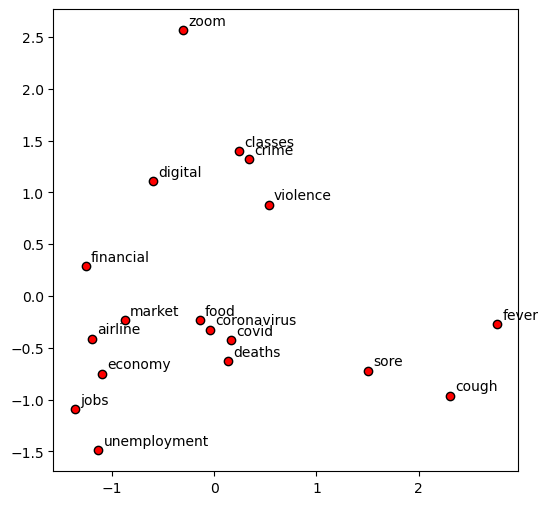

In [12]:
## QUES_3_3

word_list=['covid', 'coronavirus', 'fever', 'sore', 'cough', 'deaths', 'unemployment', 'food','financial', 'jobs', 'market', 'airline','economy', 'digital', 'zoom', 'classes', 'violence', 'crime']
list=sorted(word_list)
vectors=[]
key=[]
value=[]
for word in list:      
    words=model[word]
    vectors.append(words)
    key.append(word)
for i in range(len(vectors)):
    value.append(i)
word2Ind_ques3 = {k:v for k,v in zip(key,value)}

ques3_2_value_str = [str(value[0][0]) for value in ques3_2.values()]
keyof_ques3_2=[]
for i in ques3_2.keys():
    keyof_ques3_2.append(i)

ques3_2_dict={k:v for k,v in zip(keyof_ques3_2,ques3_2_value_str)}

M2d_fasttext_ques3=project_on_pca(model, list, fname ='pca3.JPG')

print(word2Ind_ques3)
print(ques3_2_dict)
print(M2d_fasttext_ques3)


# Compare the result with those in Question 2 d).
Compare to the result in Question 2d, this gives a better outcome. We get some appropriate groups of words appear on the plot such as 'coronavirus'- 'covid'-'deaths'-'food', 'sore'-'cough'-'fever', 'job'-'economy'-'airline'-'market'-'financial', 'classes'-'crime'-'violence'
